In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
import re

In [2]:
df = pd.read_csv('climate_tweets.csv')

In [3]:
df.shape

(6090, 1)

In [4]:
df.head()

,tweet
0,Global warming report urges governments to act...
1,Fighting poverty and global warming in Africa ...
2,Carbon offsets: How a Vatican forest failed to...
3,Carbon offsets: How a Vatican forest failed to...
4,URUGUAY: Tools Needed for Those Most Vulnerabl...


In [5]:
df['Char Length'] = df['tweet'].apply(lambda x:len(x))
df.head()

,tweet,Char Length
0,Global warming report urges governments to act...,118
1,Fighting poverty and global warming in Africa ...,52
2,Carbon offsets: How a Vatican forest failed to...,75
3,Carbon offsets: How a Vatican forest failed to...,75
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,72


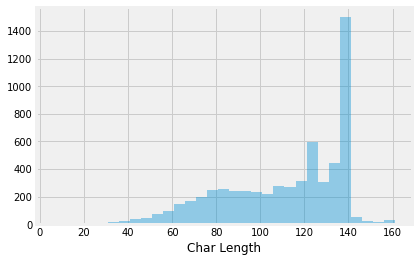

In [6]:
sns.distplot(df['Char Length'],kde=False)

In [7]:
df['tweet'].unique().shape

(5541,)

In [8]:
df['Is Retweet'] = df['tweet'].apply(lambda x:x[:2] == 'RT')
df['Is Retweet'].sum()

773

In [9]:
df[df['Is Retweet'] == True].tweet.unique().shape

(677,)

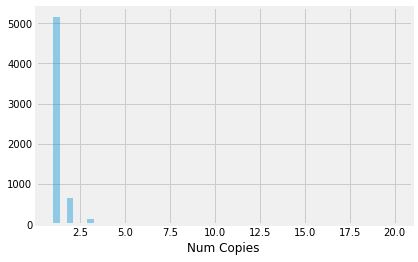

In [10]:
df['Num Copies'] = df.groupby('tweet')['Is Retweet'].transform('count')
sns.distplot(df['Num Copies'],kde=False)

In [11]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet) 

In [12]:
# two sample tweets
my_tweet = 'RT @our_codingclub: Can @you find #all the #hashtags?'
my_other_tweet = 'Not a retweet. All views @my own'

find_hashtags(my_tweet)

['#all', '#hashtags']

In [13]:
df['Retweeted'] = df['tweet'].apply(find_retweeted)
df['Mentioned'] = df['tweet'].apply(find_mentioned)
df['Hashtags'] = df['tweet'].apply(find_hashtags)
df[df['Is Retweet'] == 1].head()

,tweet,Char Length,Is Retweet,Num Copies,Retweeted,Mentioned,Hashtags
5,RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness...,106,True,2,"[@sejorg, @JaymiHeimbuch]",[],[]
23,RT @WGofNYC Leader of National Indigenous Wome...,130,True,3,[@WGofNYC],[],[]
36,RT @virgiltexas: Hey Al Gore: see these tornad...,156,True,3,[@virgiltexas],[],"[#tornadocot, #ocra, #sgp, #gop, #ucot, #tlot,..."
70,RT @redostoneage: NASAs changing Facts; Guess ...,121,True,2,[@redostoneage],[],"[#global, #climate, #eco]"
77,RT @TheBCast: The B-Cast Interview: Minnesotan...,98,True,2,[@TheBCast],[],[]


In [14]:
hashtags_df = pd.DataFrame(df[df['Hashtags'].apply(lambda x:x != [])]['Hashtags'])
retweets_df = pd.DataFrame(df[df['Retweeted'].apply(lambda x:x != [])]['Retweeted'])
mentioned_df = pd.DataFrame(df[df['Mentioned'].apply(lambda x:x != [])]['Mentioned'])

In [15]:
hashtags_df.head()

,Hashtags
12,"[#Climate, #population]"
16,[#EarthDay]
26,[#ac]
31,[#tcot]
36,"[#tornadocot, #ocra, #sgp, #gop, #ucot, #tlot,..."


In [16]:
def collect_list(object_,column_string): 
    list_of_ = []
    for ind, row in object_.iterrows():
        list_of_.extend(row[column_string])
    return pd.DataFrame({column_string: list_of_})[column_string]
hashtag_list = collect_list(hashtags_df, 'Hashtags')
retweeted_list = collect_list(retweets_df, 'Retweeted')
mentioned_list = collect_list(mentioned_df, 'Mentioned')

In [17]:
hashtag_list.value_counts().head(10)

#tcot             227
#climate          202
#p2               112
#green             50
#climatechange     47
#teaparty          41
#global            40
#eco               40
#SaveTerra         36
#climategate       33
Name: Hashtags, dtype: int64

In [18]:
retweeted_list.value_counts().head(10)

@Drudge_Report    19
@Newsweek         18
@redostoneage     12
@newtgingrich     10
@mattyglesias     10
@Cubachi           8
@democracy_now     8
@mmfa              7
@guardianeco       7
@tlw3              7
Name: Retweeted, dtype: int64

In [19]:
mentioned_list.value_counts().head(10)

@NewsOnGreen      37
@change           33
@addthis          19
@HumanityNews     17
@algore            9
@TIME              9
@guardianeco       6
@InvasiveNotes     6
@boliviaun         6
@glennbeck         6
Name: Mentioned, dtype: int64

In [20]:
hashtag_set = set(hashtag_list.value_counts()[hashtag_list.value_counts() > 10].index.values) 

In [21]:
hashtags_df['Popular Hashtags'] = hashtags_df['Hashtags'].apply(lambda lst:[hashtag for hashtag in lst if hashtag in hashtag_set])

In [22]:
hashtags_df[hashtags_df['Popular Hashtags'].apply(lambda x:x!=[])]
hashtags_df.shape

(1129, 2)

In [23]:
for hashtag in hashtag_set:
    hashtags_df[hashtag] = hashtags_df['Popular Hashtags'].apply(lambda x:1 if hashtag in x else 0)

In [24]:
hashtags_df.drop(['Popular Hashtags'],axis=1,inplace=True)

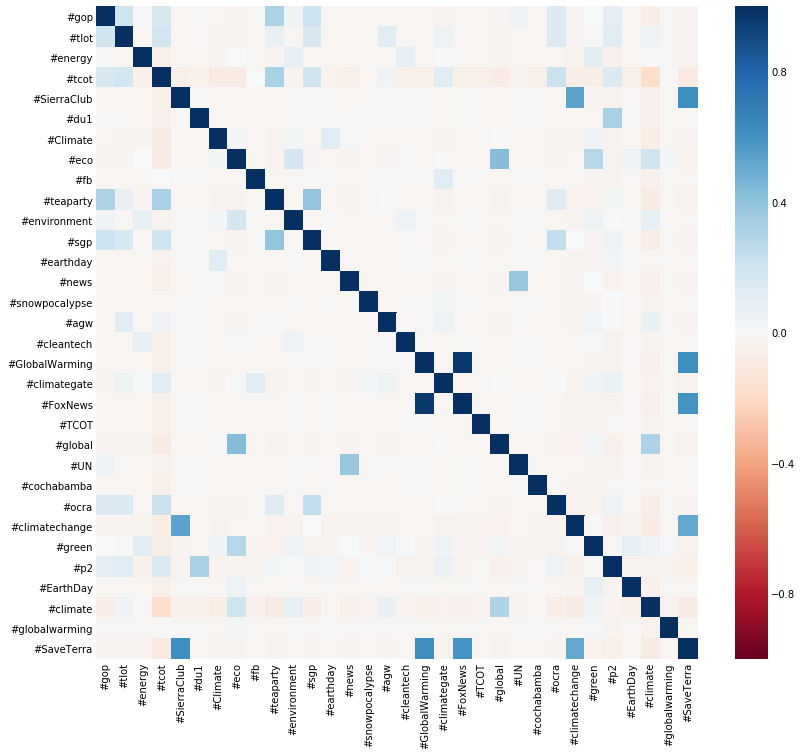

In [25]:
plt.subplots(figsize=(12,12))
sns.heatmap(hashtags_df.drop(['Hashtags'],axis=1).corr(),vmin=-1,vmax=1,cmap='RdBu')

In [26]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [27]:
#def remove_and_get_links(tweet):
    #re.findall('http/S+',tweet)
sample_link = df[df['tweet'].apply(lambda x:'http' in x)]['tweet'].reset_index()['tweet'].loc[111]
sample_link

"well this is just crazy: Coal CEO Calls Mine Safety Rules 'As Silly As Global Warming' http://bit.ly/aJTn26"

In [28]:
def remove_links(tweet):
    tweet = re.sub('http\S+','',tweet)
    tweet = re.sub('(?!http://)bit.ly/\S+','',tweet)
    tweet = tweet.strip('[link]')
    return tweet
def extract_links(tweet):
    link1 = re.findall('http\S+',tweet)
    return list(set(link1.extend(re.findall('(?!http://)bit.ly\S+',tweet))))
def remove_users(tweet):
    tweet = re.sub('@[A-Za-z]+[A-Za-z0-9-_]','',tweet)
    return tweet

In [29]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [30]:
df['Clean Tweet'] = df['tweet'].apply(clean_tweet)

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.9,min_df=0.01,token_pattern='\w+|\$[\d\.]+|\S+')

tf = vectorizer.fit_transform(df['Clean Tweet'])
feature_names = vectorizer.get_feature_names()

In [32]:
len(feature_names)

122

In [33]:
from sklearn.decomposition import LatentDirichletAllocation, NMF

def model_topics(algorithm):
    if algorithm == 'LDA':
        model = LatentDirichletAllocation(n_components=10)
    elif algorithm == 'NMF':
        model = NMF(n_components=10)
    model.fit(tf)
    model.get_params()
    topic_word_df = pd.DataFrame(model.components_,columns=feature_names)
    sorted_topic_words = pd.DataFrame()
    for index, row in topic_word_df.iterrows():
        row_df = pd.DataFrame({'topic_'+str(index): row.sort_values(ascending=False).index[:5].values})
        sorted_topic_words = pd.concat([sorted_topic_words,row_df],axis=1)
    return model, sorted_topic_words
    

In [34]:
lda_model, lda_topic_words = model_topics('LDA')
nmf_model, nmf_topic_words = model_topics('NMF')

In [35]:
lda_topic_words

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,global,climat,climat,global,rt,global,climat,climat,global,chang
1,warm,chang,chang,warm,warm,warm,chang,chang,warm,climat
2,caus,peopl,news,snow,global,scientist,bill,could,new,rt
3,dc,world,energi,gore,make,great,senat,take,obama,via
4,may,fight,via,al,#tcot,think,graham,un,call,#climate


In [36]:
nmf_topic_words

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,climat,global,rt,via,snow,new,bill,#climate,peopl,report
1,chang,warm,#p,news,gore,agenc,senat,chang,world,say
2,scienc,caus,blizzard,chang,dc,obama,graham,warm,earth,make
3,energi,#tcot,#tcot,india,al,feder,put,us,confer,wors
4,legisl,believ,make,com,#tcot,studi,climat,#p,right,caus


In [37]:
lda_model.get_params()

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': None,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}